In [440]:
import tabulator
from urllib.request import urlretrieve
import csv
import json
import logging
from math import exp
from statistics import mean, stdev, median

In [441]:
def stripstr(s):
    if s is not None: return ' '.join(s.split()).strip() 

def process_gsheet():
    urlretrieve('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ9VOjw8JrOa-8fzcnlRuooY6e8I1Bm6f-IZOzhrOYXf8RY0cfqfT-5aL11WTA3MqLG3GEaDlW0iNB-/pub?output=xlsx', 'data.xlsx')
    for sheet in range(1, 12): # [1,3,5,6,7,8,9,10,11]:
        print('SHEET', sheet)
        s=tabulator.Stream('data.xlsx', sheet=sheet, headers=1)
        try:
            s.open()
            prevkey = None
            prevret = {}
            for r in s.iter(keyed=True):
                # is valid row?
                assert 'value' in r, 'Bad ROW %r' % r
                if r['value'] is None or len(str(r['value']).strip()) == 0:
                    continue
                r.setdefault('value_cmp', None)
                # copy values from the previous row
                ret = dict(
                    (k, prevret.get(k))
                    for k in ('category', 'series', 'subseries', 'calc', 'year', 'value_docuemtation')
                )
                # update with values from the current row
                for k, v in r.items():
                    if not k:
                        continue
                    if v is not None:
                        ret[k] = v
                    else:
                        if k not in ret:
                            ret[k] = None
                # if series changed - reset value documentation
                key = '{category}/{series}/{subseries}'.format(**r)
                if key != prevkey:
                    ret['value_docuemtation'] = None
                # process datatypes a tad
                for k, f in (
                    ('year', int), 
                    ('extrapulation', bool), 
                    ('category', stripstr), 
                    ('series', stripstr), 
                    ('subseries', stripstr)
                ):
                    ret[k] = f(ret.get(k))
                    
                yield ret
                prevkey, prevret = key, ret
                    
        except tabulator.exceptions.SourceError:
            break

In [442]:
def collate_series(rows):
    series = {}
    for r in rows:
        key = '{category}/{series}/{subseries}'.format(**r)
        values = series.setdefault(key, {
            'kind': 'series',
            'category': r['category'],
            'series': r['series'],
            'subseries': r['subseries'],
            'title': r['subseries'],
            'calc': r['calc'],
            'values': []
        })['values']
        values.append({
            'year': r['year'],
            'value': r['value'],
            'value_cmp': r['value_cmp'],
            # TODO: copy src_url, src_title, value_docuemtation, extrapulation
        })
    return series
    


In [443]:
def two_parts(v1, v2, _):
    if v2 is not None:
        ratio = v1/(v1+v2)
        assert 0 <= ratio <= 1
        score = 100*(exp(    
            -((ratio-0.5)**2) / (2*(0.16**2))
        ))
        return score

In [444]:
def two_parts_percent(v1, v2, _):
    assert 0 <= v1 <= 1
    if v2 is None:
        v2 = 1 - v1
    return two_parts(v1, v2, _)

In [445]:
def two_values(v1, v2, _):
    return two_parts(v1, v2, _)

In [446]:
def none(v1, v2, _):
    return (1-v1)*100

In [447]:
def index(v1, v2, norm):
    return 100 - (v1/norm)*100

In [457]:
def index_norm(v1, v2, norm):
    print(v1, v2, norm)
    if v2:
        return 100 - ((v1/v2)/norm)*100

In [467]:
def calc_scores(series):
    for k, s in series.items():
        try:
            calc = globals()[s['calc']]
        except:
            logging.error('BAD CALC %r, %r', k, s)
        norm_value = 0
        for v in s['values']:
            if s['calc'] == 'index_norm':
                if v['value_cmp']:
                    norm_value = max(norm_value, v['value'] / v['value_cmp'])
            else:
                norm_value = max(norm_value, v['value'])
        if calc=='index':
            assert norm_value, 'BAD ROW %r %r' % (k, s) 
        for v in s['values']:
            try:
                v['score'] = calc(v['value'], v['value_cmp'], norm_value)
            except:
                assert False, 'BAD ROW %r %r' % (k, s) 
            assert v['score'] is None or (0 <= v['score'] <= 100), 'BAD VALUE %r, %r, %r' % (v['score'], k, s)
        s['values'] = [x for x in s['values'] if x['score'] is not None]
    return series


In [468]:
def calc_averages(series, kf='{category}', title=None):
    avgs = {}
    for s in series.values():
        k = kf.format(**s)
        a = avgs.setdefault(k, {
            'kind': 'avg' if kf != 'total' else 'total',
            'category': k,
            'title': title if title is not None else k,
#             'series': set(),
            'values': {}
        })
#         a['series'].add(s['title'])
        for v in s['values']:
            a['values'].setdefault(v['year'], []).append(v['score'])
    for a in avgs.values():
        values = []
        for year, scores in a['values'].items():
            values.append({
                'year': year,
                'score': mean(scores),
                'error': stdev(scores) if len(scores)>1 else 0,
                'count': len(scores)
            })
        median_count = median(map(lambda x:x['count'], values))
        a['values'] = sorted(filter(lambda x:x['count']>=median_count, values), key=lambda v:v['year'])
#         a['series'] = list(a['series'])
    series.update(avgs)
    if len(avgs) > 1:
        series.update(calc_averages(avgs, kf='total', title='מדד המגדר'))
    return series
            

In [469]:
series = collate_series(process_gsheet())
series = calc_scores(series)
series = calc_averages(series)


SHEET 1
SHEET 2
SHEET 3
SHEET 4
SHEET 5
SHEET 6
SHEET 7
SHEET 8
SHEET 9
SHEET 10
SHEET 11
1160.0 None 3.4710935686092412
1499.0 None 3.4710935686092412
4154.0 None 3.4710935686092412
6012.0 None 3.4710935686092412
5236.0 None 3.4710935686092412
7073.0 None 3.4710935686092412
7085.0 None 3.4710935686092412
8669.0 None 3.4710935686092412
7802.0 None 3.4710935686092412
6982.0 None 3.4710935686092412
8049.0 2540.0 3.4710935686092412
8970.0 2584.2 3.4710935686092412
8862.0 2629.7 3.4710935686092412
8729.0 2674.8 3.4710935686092412
7793.0 2720.8 3.4710935686092412
7594.0 2766.8 3.4710935686092412
7845.0 2811.2 3.4710935686092412
7930.0 2859.4 3.4710935686092412
7700.0 2905.1 3.4710935686092412
8637.0 2956.7 3.4710935686092412
8938.0 3008.39 3.4710935686092412
9197.0 3067.2 3.4710935686092412
670.0 2540.0 0.49947835159102766
698.0 2584.2 0.49947835159102766
854.0 2629.7 0.49947835159102766
955.0 2674.8 0.49947835159102766
894.0 2720.8 0.49947835159102766
829.0 2766.8 0.49947835159102766
962.0

In [470]:
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18, 18)

def reverse(s): return ''.join(reversed(s))
filtered = [(k, s) for k, s in series.items()]# if k.startswith('מיגדור מקצועי/')]

minyear = max(min(x['year'] for x in s['values']) for _, s in filtered)
maxyear = 2014 # min(max(x['year'] for x in s['values']) for _, s in filtered)
for k, s in filtered:
    s['values'] = list(filter(lambda v: maxyear >= v['year'] >= minyear, s['values']))
    s['key'] = k
filtered = [s for k, s in filtered] 

json.dump(filtered, open('filtered.json', 'w'))

In [471]:
from numpy import sign
def svg_widget(t):
    main, key, _, val, slope = t
    title = key.split('/')[-1]
    style = '14' if title == main else '8'
    rads = val/100*math.pi
    rotate= val/100*180
    dialx = 60 - 50*math.cos(rads)
    dialy = 100 - 50*math.sin(rads)
    red = int(255 - val)
    green = int(155 + val)
    blue = 155
    trend=-slope*5-3*sign(slope)
    lineend=trend+sign(slope)*3
    color = '#%02x%02x%02x' % (red, green, blue)
    return """
<div style="display: inline-block;width:120px;vertical-align:top;">
<svg width="120" height="120">
    <path style="stroke: {color};fill:{color}" d="M10,100A50,50,1,1,1,110,100"/>
    <path style="stroke: black;fill:none" d="M60,100L{dialx},{dialy}"/>
    <g transform="translate({dialx},{dialy}),rotate({rotate})">
        <path style="stroke:black;fill:none" d="M0,0L0,{trend}L5,{lineend},M0,{trend}L-5,{lineend}">
    </g>
</svg>
<div style="display:inline-block;height:40px;width:120px;font-size:{style}px;">
<center>
{title}
</center>
</div>
</div>
""".format(title=title, style=style, dialx=dialx, dialy=dialy, 
           color=color, trend=trend, lineend=lineend,
           rotate=rotate)
#     <text x="60" y="125" style="text-anchor:middle;fill:black;" font-size="{style}">{title}</text>


In [463]:
from scipy.stats import linregress
import itertools
trends = []
for f in filtered:
    x = [t['year'] for t in f['values']]
    y = [t['score'] for t in f['values']]
    lr = linregress(x=x, y=y)
    trends.append((f['key'].split('/')[0], f['key'], x[-1], y[-1], lr.slope))
    if 'לפרקליטות' in f['key'] and f['category']=='אלימות':
        import pprint
        pprint.pprint(f)
trends = sorted(trends, key=lambda x:x[0])
trends = itertools.groupby(trends, key=lambda x:x[0])
t = {}
html = "<html><body>"
for k, g in trends:
    t[k] = sorted(g, key=lambda x:x[3])
    html += '<div style="border-bottom:1px solid">'
    html += ''.join(svg_widget(p) for p in t[k])
    html += '</div>'
html += '</body></html>'
open('/Users/adam/code/genderdb/interactions/demo2/widgets.html', 'w').write(html)

{'calc': 'index_norm',
 'category': 'אלימות',
 'key': 'אלימות/None/תיקים שהועברו לתביעה המשטרתית או לפרקליטות',
 'kind': 'series',
 'series': None,
 'subseries': 'תיקים שהועברו לתביעה המשטרתית או לפרקליטות',
 'title': 'תיקים שהועברו לתביעה המשטרתית או לפרקליטות',
 'values': [{'score': 99.95968612937172,
             'value': 698.0,
             'value_cmp': 2584.2,
             'year': 2005},
            {'score': 99.95152957121833,
             'value': 854.0,
             'value_cmp': 2629.7,
             'year': 2006},
            {'score': 99.94671103879436,
             'value': 955.0,
             'value_cmp': 2674.8,
             'year': 2007},
            {'score': 99.95095823440867,
             'value': 894.0,
             'value_cmp': 2720.8,
             'year': 2008},
            {'score': 99.95527998291037,
             'value': 829.0,
             'value_cmp': 2766.8,
             'year': 2009},
            {'score': 99.94892498237328,
             'value': 962.0,
      

64643

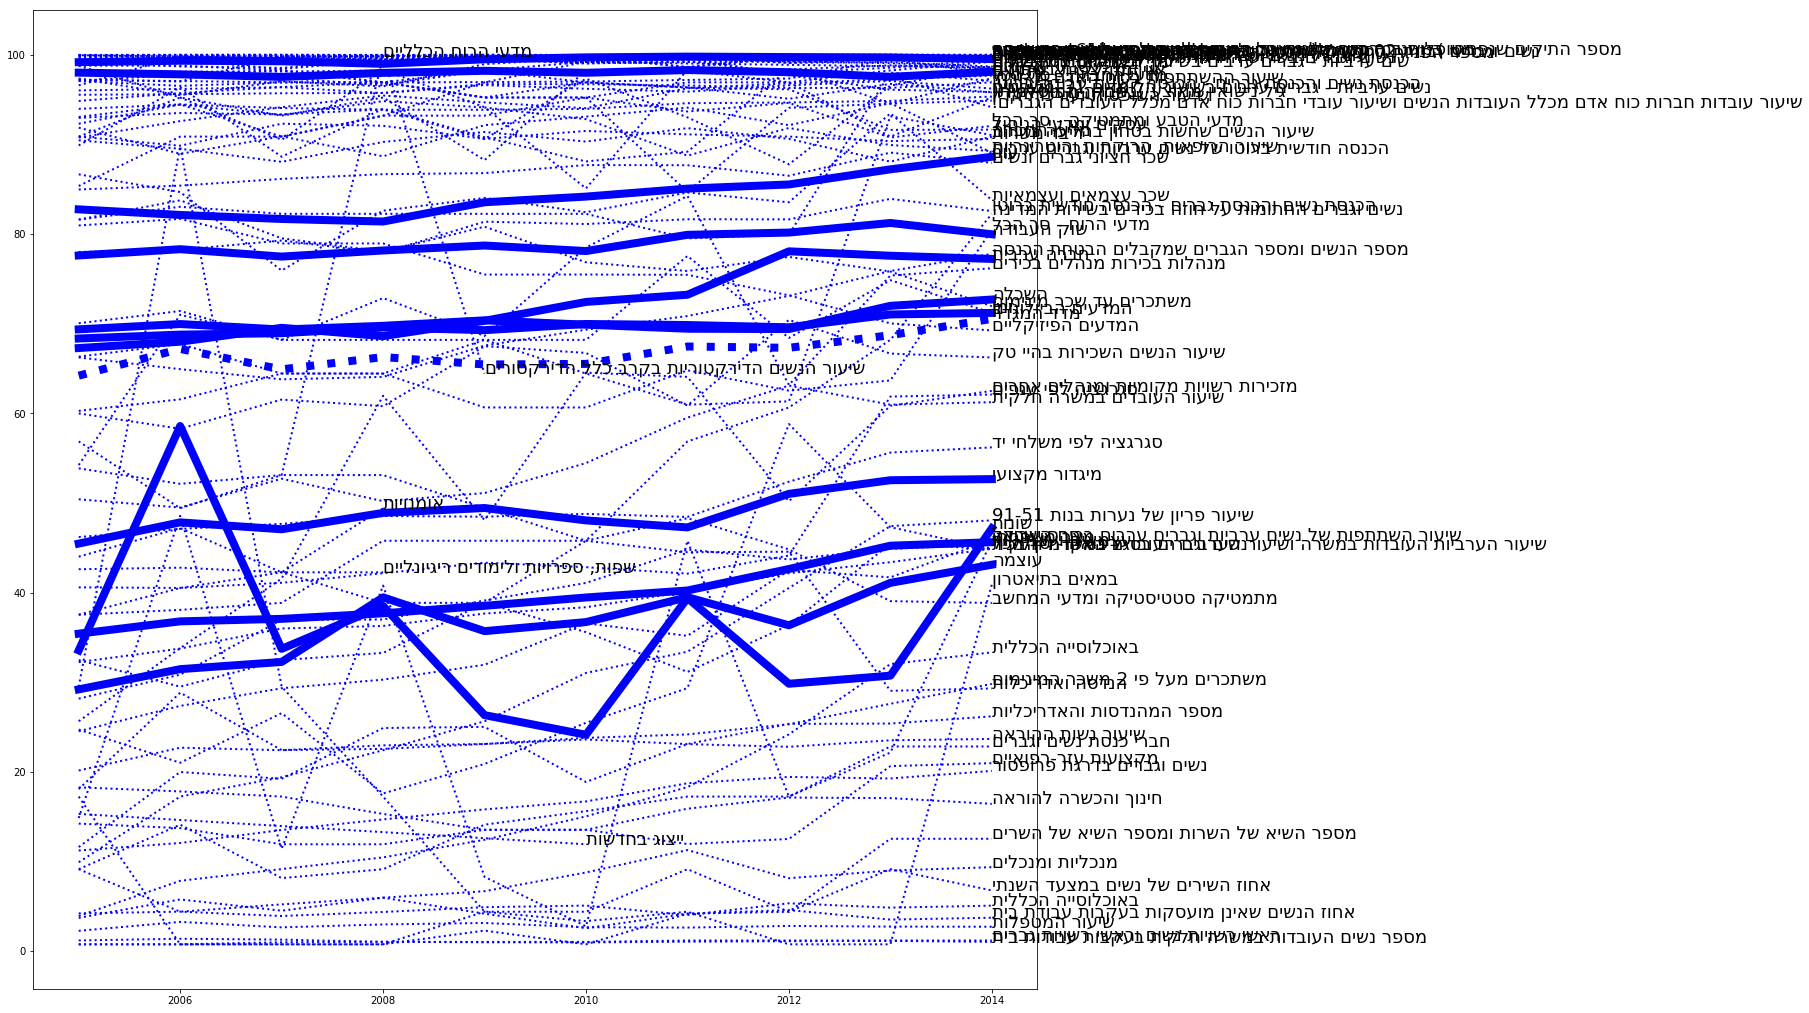

In [348]:
for s in filtered:
    width = 2**(4-len(s['key'].split('/')))
    style = 'b-' if s['kind'] == 'avg' else 'b:'
    y = [v['score'] for v in s['values']]
    x = [v['year'] for v in s['values']]
    plt.plot(x, y, style, linewidth=width)
    plt.text(x[-1], y[-1], reverse(s['title']), fontsize=18)
# plt.show()

w = csv.DictWriter(open('data.csv', 'w'), [
    'category', 'series', 'subseries', 
    'calc', 'year', 
    'value', 'value_cmp', 
    'src_url', 'src_title', 
    'value_docuemtation', 'extrapulation'
])
w.writeheader()
w.writerows(it)